In [1]:
import numpy as np, GPy, pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

/home/maxz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
 /home/maxz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning:axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.


# Trajectory Simulation

We simulate the number of data and some number of classes in a high number of dimensions

The classes are along a timeline from 0 to 10. Each class has a normal distribution around a random center point, where the variance is proportional to the size of the class

In [2]:
%run simulate_trajectory
from run_methods import run_methods

In [3]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding, Isomap
from sklearn.decomposition import FastICA, PCA

seeds = [8971, 3551, 3279, 5001, 5081]

methods = {'t-SNE':TSNE(n_components=2),
           'PCA':PCA(n_components=2), 
           'Spectral': SpectralEmbedding(n_components=2, n_neighbors=10), 
           'Isomap': Isomap(n_components=2, n_neighbors=10), 
           'ICA': FastICA(n_components=2)
           }

Now we can use this latent trajectory in order to push it through a non linear mapping up into higher dimensions.
In order for all methods to be able to pick out the time information more easily we slightly hint at the time information by including its covariance in a non-linear manner and with a tenth of magnitude into the covariance structure we sample from.

The variance added now is technical variance, whereas the variance before was biological variance!

We choose a high technical variance in order to ensure a realistic experiment setting. 

We will also run several examples increasing the technical variance and see how the trajectory is recovered using different methods.

 /home/maxz/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


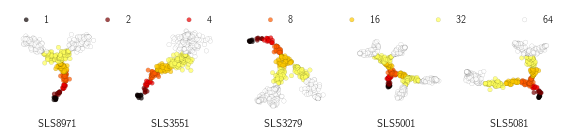

In [4]:
fig = plt.figure(figsize=(8,2), tight_layout=True)

gs = plt.GridSpec(6, 5)

axit = iter([fig.add_subplot(gs[1:, i]) for i in range(5)])

for seed in seeds:
    Xsim, simulate_new, t, c, labels, seed = guo_simulation(seed=seed)
    ax = next(axit)

    prevlab = None
    for lab in labels:
        if lab != prevlab:
            color = plt.cm.hot(c[lab==labels])
            ax.scatter(*Xsim[lab==labels].T, c=color, alpha=.7, lw=.1, label=lab)
            prevlab = lab
        
    ax.set_xlabel("SLS{}".format(seed))
    ax.set_frame_on(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

leg_hand = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, :])
ax.legend(*leg_hand, ncol=7, mode='expand')
ax.set_frame_on(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig('../diagrams/simulation/simulated_latent_spaces.pdf')

## Comparison

We will use SLS5001 to compare to the other methods in order to show how Manifold works.
We also set the seeds for the simulation (y_seed) in order to get consistent results.

In [5]:
seed = 5001
y_seed = 0

In [6]:
Xsim, simulate_new, t, c, labels, seed = guo_simulation(seed=seed)

np.random.seed(y_seed)
Y = simulate_new()

In [7]:
#plot_dist_hist(Y)
X_init, dims = run_methods(Y, methods)

In [8]:
m = GPy.models.BayesianGPLVM(Y, 10, X=X_init, num_inducing=35)

In [9]:
m.likelihood.fix(.1)
m.kern.lengthscale.fix()
m.optimize(max_iters=500, messages=True, clear_after_finish=True)
m.likelihood.unfix()
m.kern.unfix()
m.optimize(max_iters=5e3, messages=True, clear_after_finish=False)

5001


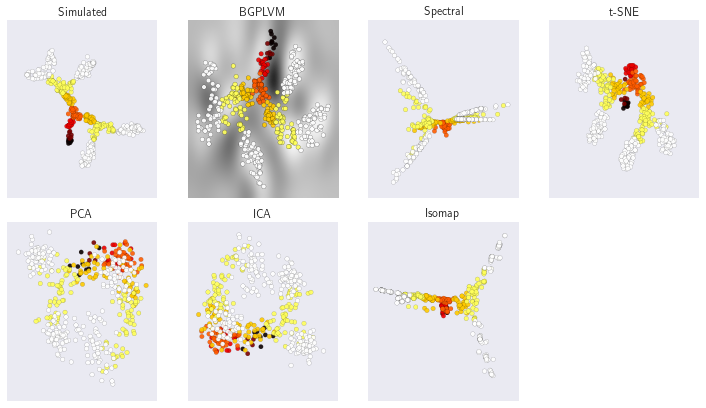

In [10]:
fig, axes = plt.subplots(2,4,figsize=(10,6))
axit = axes.flat
cols = plt.cm.hot(c)

ax = next(axit)
ax.scatter(*Xsim.T, c=cols, cmap='hot', lw=.1)
ax.set_title('Simulated')
ax.set_xticks([])
ax.set_yticks([])

ax = next(axit)
msi = m.get_most_significant_input_dimensions()[:2]
#ax.scatter(*m.X.mean.values[:,msi].T, c=t, cmap='hot')
#m.plot_inducing(ax=ax, color='w')
m.plot_magnification(resolution=20, scatter_kwargs=dict(color=cols, cmap='hot', s=20), marker='o', ax=ax)
ax.set_title('BGPLVM')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

for name in methods:
    ax = next(axit)
    ax.scatter(*X_init[:,dims[name]].T, c=cols, cmap='hot', lw=.1)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
print seed
ax = next(axit)
ax.set_visible(False)
#plt.savefig('../diagrams/simulation/{}_comparison.pdf'.format(seed), transparent=True, bbox_inches='tight')

## Waddington's landscape

First we plot the probabilistic interpretation of Waddington's landscape as a three dimensional plot, where the z direction of the plot shows the magnification factor. We always want to be in the ravines of the plot, and not cross over hills.

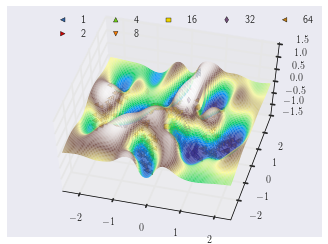

In [11]:
from manifold import waddington_landscape, plot_waddington_landscape

res = 120
Xgrid, wadXgrid, X, wadX = waddington_landscape(m, resolution=res)
ax = plot_waddington_landscape(Xgrid, wadXgrid, X, wadX, np.unique(labels), labels, resolution=res)
ax.view_init(elev=56, azim=-75)

Then we inspect the landscape a little closer (distances and graph embeddings). This also will reveal the pseudo time and comparisons to the simulated times.

In [12]:
from manifold import ManifoldCorrectionTree, ManifoldCorrectionKNN
import networkx as nx

 /home/maxz/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /home/maxz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning:axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.


MST spanning through the data


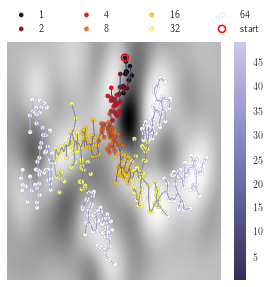

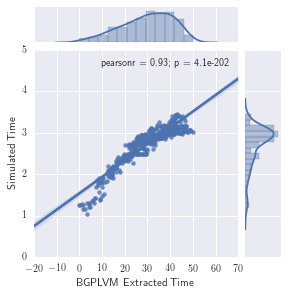

In [13]:
msi = m.get_most_significant_input_dimensions()[:2]
X = m.X.mean[:,msi]
pos = dict([(i, x) for i, x in zip(range(X.shape[0]), X)])

mc = ManifoldCorrectionTree(m)

start = 6

pt = mc.distances_along_graph
pt_graph = mc.get_time_graph(start)

G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(4,4))

m.plot_magnification(ax=ax, plot_scatter=False)
prevlab = None
for lab in labels:
    if lab != prevlab:
        color = plt.cm.hot(c[lab==labels])
        ax.scatter(*X[lab==labels].T, c=color, alpha=.9, lw=.1, label=lab)
        prevlab = lab
    
ecols = [e[2]['weight'] for e in G.edges(data=True)]
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True, start=0, rot=0, dark=.2, light=.8, )

edges = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=ecols, edge_cmap=cmap, lw=2)
cbar = fig.colorbar(edges, ax=ax)
#cbar.set_ticks([1,13/2.,12])
#ax.set_xlim(-3,2)
#ax.set_ylim(-3,2.2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

ax.scatter(*X[start].T, edgecolor='red', lw=1.5, facecolor='none', s=50, label='start')

ax.legend(bbox_to_anchor=(0., 1.02, 1.2, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)

fig.tight_layout(rect=(0,0,1,.9))
#fig.savefig('../diagrams/simulation/BGPLVMtree_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pt[start], t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('BGPLVM Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
#ax.ax_joint.figure.savefig('../diagrams/simulation/BGPLVM_time_scatter_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

#fig, ax = plt.subplots(figsize=(4,4))
#msi = m.get_most_significant_input_dimensions()[:2]
#ax.scatter(*m.X.mean.values[:,msi].T, c=t, cmap='hot')
#m.plot_inducing(ax=ax, color='w')
#m.plot_magnification(resolution=20, scatter_kwargs=dict(color=cols, cmap='hot', s=20), marker='o', ax=ax)
#ax.set_title('BGPLVM')
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.set_xticks([])
#ax.set_yticks([])
#ax.figure.savefig('../diagrams/simulation/BGPLVM_magnificaton_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

print("MST spanning through the data")

The model tells us that we only need the two dimensions shown above. 
The significance of dimensions of the underlying function (defined by the kernel) can be plotted by plotting the ARD parameters. If the sensitivity for a dimension is close to 0 it is not used by the BGPLVM. The higher it is, the more non-linear the fit is for that dimension (actually the more 'wiggly' it gets). 

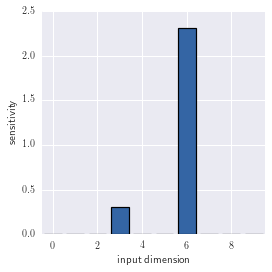

In [14]:
fig, ax = plt.subplots(figsize=(4,4))
m.kern.plot_ARD(ax=ax)
#fig.savefig('../diagrams/simulation/BGPLVM_ARD_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

3 Nearest Neighbor embedding and extracted time along it for the same Manifold embedding


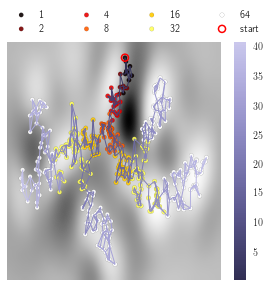

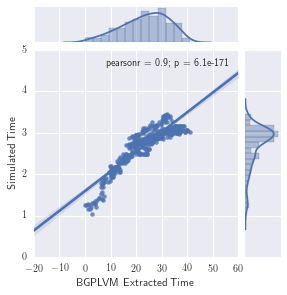

In [15]:
msi = m.get_most_significant_input_dimensions()[:2]
X = m.X.mean[:,msi]
pos = dict([(i, x) for i, x in zip(range(X.shape[0]), X)])

mc = ManifoldCorrectionKNN(m, 4)

start = 6

pt = mc.distances_along_graph
pt_graph = mc.get_time_graph(start)
G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(4,4))

m.plot_magnification(ax=ax, plot_scatter=False)
prevlab = None
for lab in labels:
    if lab != prevlab:
        color = plt.cm.hot(c[lab==labels])
        ax.scatter(*X[lab==labels].T, c=color, alpha=.9, lw=.1, label=lab)
        prevlab = lab
    
ecols = [e[2]['weight'] for e in G.edges(data=True)]
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True, start=0, rot=0, dark=.2, light=.8, )

edges = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=ecols, edge_cmap=cmap, lw=1.5)
cbar = fig.colorbar(edges, ax=ax)
#cbar.set_ticks([1,13/2.,12])
#ax.set_xlim(-3,2)
#ax.set_ylim(-3,2.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_frame_on(False)

ax.scatter(*X[start].T, edgecolor='red', lw=1.5, facecolor='none', s=50, label='start')

ax.legend(bbox_to_anchor=(0., 1.02, 1.2, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)

fig.tight_layout(rect=(0,0,1,.9))
#fig.savefig('../diagrams/simulation/BGPLVMknn_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pt[start], t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('BGPLVM Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
#ax.ax_joint.figure.savefig('../diagrams/simulation/BGPLVM_knn_time_scatter_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

print ("3 Nearest Neighbor embedding and extracted time along it for the same Manifold embedding")

In [16]:
i = 0
for method in methods:
    print method, '{}:{}'.format(dims[method].start, dims[method].stop)
    i+=2

Spectral 0:2
t-SNE 2:4
PCA 4:6
ICA 6:8
Isomap 8:10


In [17]:
from scipy.spatial.distance import squareform, pdist

In [18]:
%run graph_extraction.py

Monocle (MST on ICA embedding)


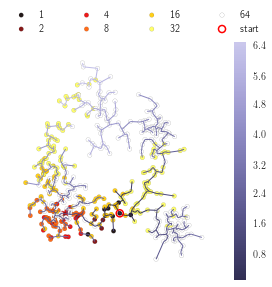

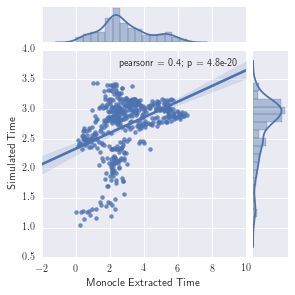

In [19]:
# Monocle:

X = X_init[:,dims['ICA']].copy()
pos = dict([(i, x) for i, x in zip(range(X.shape[0]), X)])

start = 6

pt, mst = extract_manifold_distances_mst(squareform(pdist(X)))
pt_graph = extract_distance_graph(pt, mst, start)
G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(4,4))

prevlab = None
for lab in labels:
    if lab != prevlab:
        color = plt.cm.hot(c[lab==labels])
        ax.scatter(*X[lab==labels].T, c=color, alpha=.9, lw=.1, label=lab)
        prevlab = lab
        
ecols = [e[2]['weight'] for e in G.edges(data=True)]
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True, start=0, rot=0, dark=.2, light=.8, )

edges = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=ecols, edge_cmap=cmap, lw=1.5)
cbar = fig.colorbar(edges, ax=ax)
#cbar.set_ticks([1,13/2.,12])
#ax.set_xlim(-3,2)
#ax.set_ylim(-3,2.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

ax.scatter(*X[start].T, edgecolor='red', lw=1.5, facecolor='none', s=50, label='start')

ax.legend(bbox_to_anchor=(0., 1.02, 1.2, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)

fig.tight_layout(rect=(0,0,1,.9))
#fig.savefig('../diagrams/simulation/ICA_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pt[start], t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('Monocle Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
#ax.ax_joint.figure.savefig('../diagrams/simulation/ICA_time_scatter_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

print("Monocle (MST on ICA embedding)")

In [20]:
from scipy.sparse import lil_matrix, find

Wanderlust (KNN on t-SNE)


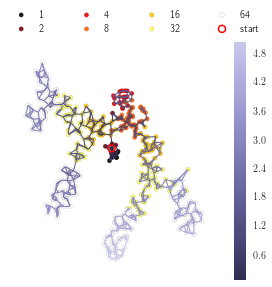

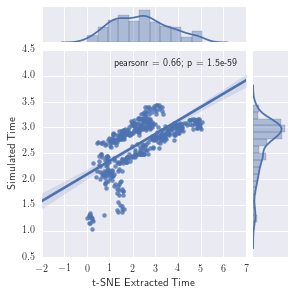

In [21]:
# Wanderlust (without smoothing)

# take out tsne:
X = X_init[:,dims['t-SNE']].copy()
pos = dict([(i, x) for i, x in zip(range(X.shape[0]), X)])

k = 4
start = 6

_, mst = extract_manifold_distances_mst(squareform(pdist(X)))
pt, knn = extract_manifold_distances_knn(squareform(pdist(X)), knn=[k], add_mst=mst).next()
pt_graph = extract_distance_graph(pt, knn, start)
G = nx.Graph(pt_graph)

G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(4,4))

prevlab = None
for lab in labels:
    if lab != prevlab:
        color = plt.cm.hot(c[lab==labels])
        ax.scatter(*X[lab==labels].T, c=color, alpha=.9, lw=.1, label=lab)
        prevlab = lab
        
ecols = [e[2]['weight'] for e in G.edges(data=True)]
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True, start=0, rot=0, dark=.2, light=.8, )

edges = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=ecols, edge_cmap=cmap, lw=1.5)
cbar = fig.colorbar(edges, ax=ax)
#cbar.set_ticks([1,13/2.,12])
#ax.set_xlim(-3,2)
#ax.set_ylim(-3,2.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

ax.scatter(*X[start].T, edgecolor='red', lw=1.5, facecolor='none', s=50, label='start')

ax.legend(bbox_to_anchor=(0., 1.02, 1.2, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)

fig.tight_layout(rect=(0,0,1,.9))
#fig.savefig('../diagrams/simulation/TSNE_knn_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pt[start], t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('t-SNE Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')

print("Wanderlust (KNN on t-SNE)")